In [2]:
library(tidyverse)
library(coin)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Lade nötiges Paket: survival



In [3]:
path_titles = "titles.csv"
path_credits = "credits.csv"

In [4]:
df_titles = read.csv(path_titles)
df_credits = read.csv(path_credits)

In [5]:
sapply(df_titles, class)

id                title                 type 
         "character"          "character"          "character" 
         description         release_year    age_certification 
         "character"            "integer"          "character" 
             runtime               genres production_countries 
           "integer"          "character"          "character" 
             seasons              imdb_id           imdb_score 
           "numeric"          "character"            "numeric" 
          imdb_votes      tmdb_popularity           tmdb_score 
           "numeric"            "numeric"            "numeric"

In [6]:
# Remove brackets and empty spaces from genres and production countries
df_titles = df_titles %>% mutate(genres = gsub("\\[|\\]| |\'", "", genres)) %>% mutate(production_countries = gsub("\\[|\\]| |\'", "", production_countries)) 

In [7]:
# Split genres into rows to count na values per genre and count na values in imdb and tmdb score per genre
df_titles %>% separate_longer_delim(genres, delim  = ",") %>% 
  group_by(genres) %>%
  summarise(total_count = n(),
            na_count_imdb = sum(is.na(imdb_score)),
            na_percentage_imdb = (na_count_imdb / total_count) * 100,
            na_count_tmdb = sum(is.na(tmdb_score)),
            na_percentage_tmdb = (na_count_tmdb / total_count) * 100) %>%
  arrange(na_percentage_imdb, na_percentage_tmdb)

genres,total_count,na_count_imdb,na_percentage_imdb,na_count_tmdb,na_percentage_tmdb
<chr>,<int>,<int>,<dbl>,<int>,<dbl>
sport,170,0,0.000000,2,1.1764706
history,254,0,0.000000,4,1.5748031
romance,971,16,1.647786,30,3.0895984
fantasy,630,11,1.746032,10,1.5873016
crime,936,27,2.884615,18,1.9230769
horror,378,12,3.174603,8,2.1164021
european,443,15,3.386005,4,0.9029345
thriller,1228,48,3.908795,27,2.1986971
action,1157,48,4.148660,34,2.9386344


In [8]:
# Pick genres with the least na values in imdb and tmdb score
selected_genres = c('fantasy', 'crime')
titles_cleaned = df_titles %>% filter(grepl(paste(selected_genres, collapse="|"), genres)) %>% filter(!is.na(imdb_score) & !is.na(tmdb_score))

In [9]:
# Create mapping for tv and movie ratings in approximate order of their severity
rating_mapping_movie = c( "not-rated" = 0, "G" = 1, "PG" = 2, "PG-13" = 3, "R" = 4, "NC-17" = 5)
rating_mapping_show = c( "not-rated" = 0, "TV-G" = 1, "TV-Y" = 2, "TV-Y7" = 3, "TV-PG" = 4, "TV-14" = 5,  "TV-MA" = 6)

# Replace empty strings in age certification by "not-rated"
titles_cleaned$age_certification = replace(titles_cleaned$age_certification, titles_cleaned$age_certification=='', "not-rated")

# Replace empty strings in production countries by "Unkown"
titles_cleaned$production_countries = replace(titles_cleaned$production_countries, titles_cleaned$production_countries=='', "Unknown")


In [10]:
# Analyse the imdb score


	Shapiro-Wilk normality test

data:  titles_cleaned$imdb_score
W = 0.98214, p-value = 1.815e-12


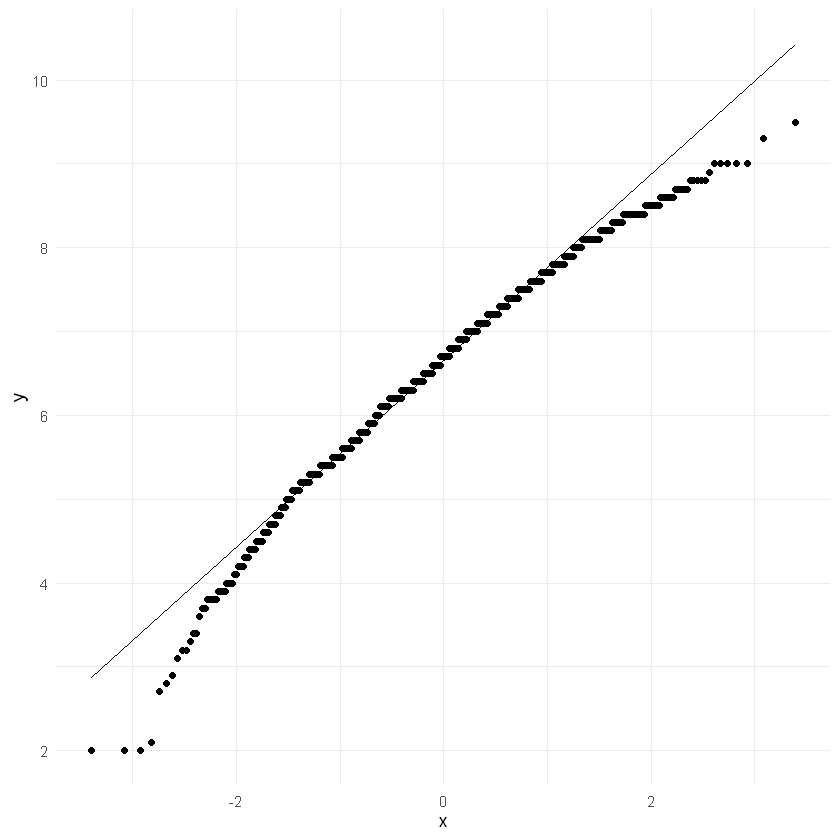

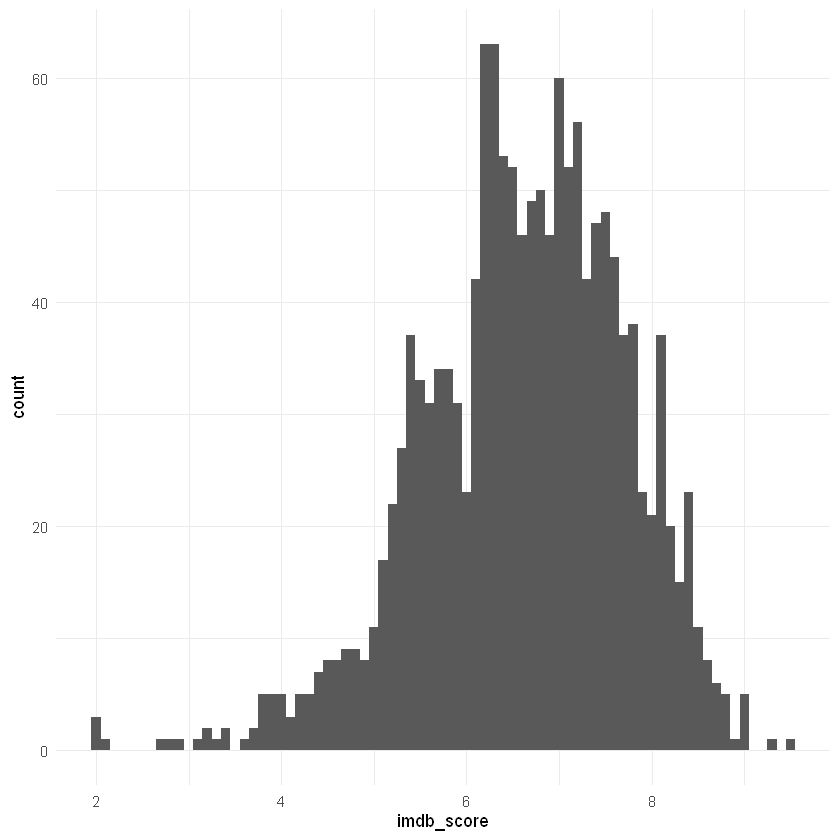

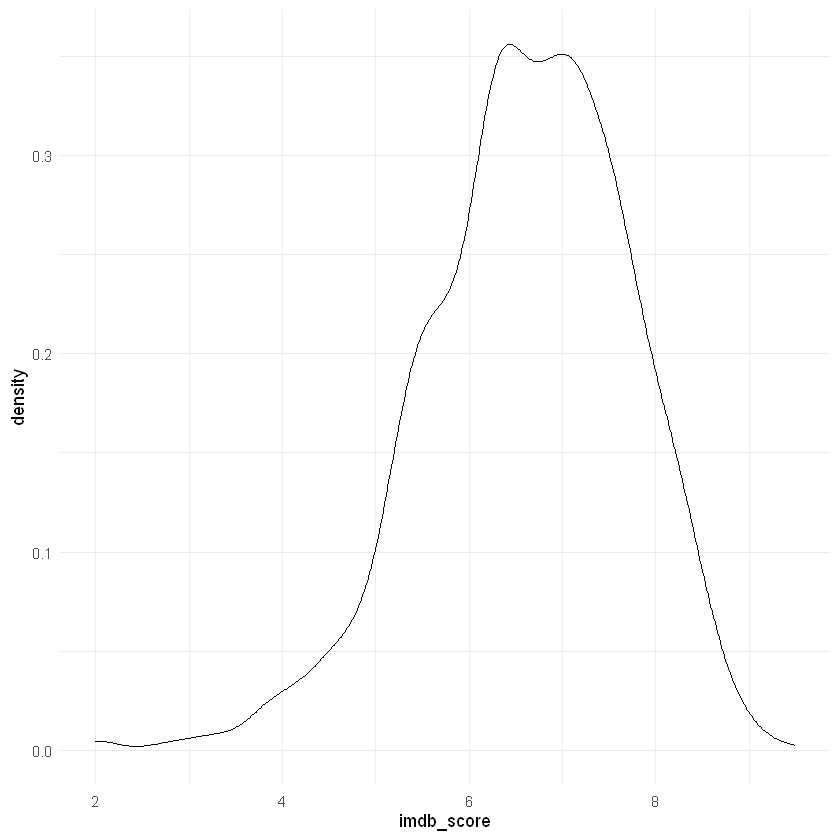

In [11]:
# Check for normality 
shapiro.test(titles_cleaned$imdb_score)
ggplot(titles_cleaned, aes(sample=imdb_score)) + stat_qq() + stat_qq_line() + theme_minimal()
ggplot(titles_cleaned, aes(x = imdb_score)) + geom_histogram(binwidth = 0.1) + theme_minimal()
ggplot(titles_cleaned, aes(x = imdb_score)) + geom_density() + theme_minimal()

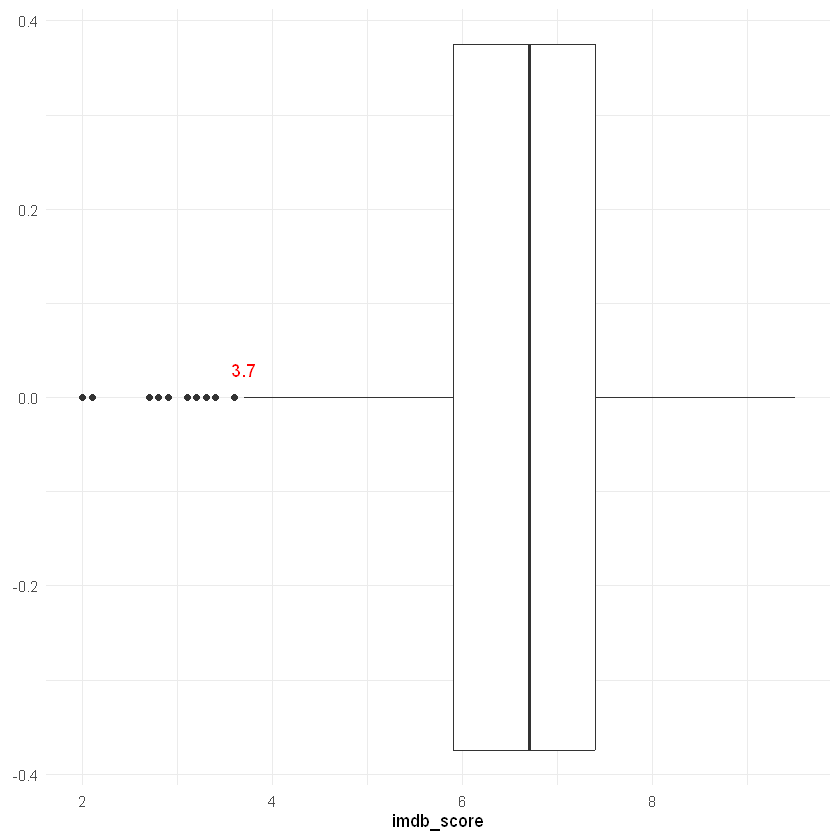

In [12]:
# Check for outliers in imdb score 
ggplot(titles_cleaned, aes(imdb_score)) +
  geom_boxplot() +
  geom_text(
    aes(label = after_stat(xmin), x = stage(imdb_score, after_stat = xmin)), 
    nudge_y = 0.03, stat = "boxplot", color = "red") + theme_minimal()

In [13]:
quantile(titles_cleaned$imdb_score)

0%  25%  50%  75% 100% 
 2.0  5.9  6.7  7.4  9.5

In [14]:
# show outliers
titles_cleaned %>% filter(imdb_score < 3.7)

id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
tm94651,Dostana,MOVIE,"Two close friends decide to enter law enforcement, one as a police officer, the other as a lawyer, but their friendship begins to unravel when they both fall in love with the same woman.",1980,not-rated,161,"drama,comedy,crime,romance,action",IN,NA,tt0080653,2.1,25,3.980,4.90
tm34142,Department,MOVIE,A police inspector recruits a suspended cop for a specialized task force to battle organized crime.,2012,R,141,"action,thriller,crime",IN,NA,tt2186731,3.2,1058,2.125,6.00
tm215911,Ludo,MOVIE,"Needing a secluded place for a late-night tryst, two couples stow away in a mall after hours, but are quickly ensnared in a gruesome and deadly game.",2015,not-rated,90,"horror,thriller,fantasy",IN,NA,tt3724898,2.8,852,3.316,2.80
tm246810,Santa Banta Pvt Ltd,MOVIE,Two friends and their sweet and endearing misadventures and one of these misadventures sees them land in the middle of a kidnapping investigation.,2016,not-rated,112,"comedy,action,crime,drama",IN,NA,tt2909396,2.7,283,2.241,3.80
tm350727,Hajwala: The Missing Engine,MOVIE,"Khalid and Kehailan are two team leaders who are passionate about car racing and challenges. They enter into a crazy competition to win the challenge involving a lot of surprises, which unexpectedly change both their lives.",2016,R,96,"drama,action,crime,sport,thriller",AE,NA,tt6200274,2.0,255,1.389,6.20
ts56201,Cloudy with a Chance of Meatballs,SHOW,"The series is a prequel, featuring the high school years of Flint Lockwood, the eccentric young scientist in the films. In his adventures, he will be joined by Sam Sparks, a new girl in town and the school's ""wannabe"" reporter, along with Flint's dad Tim, Steve the Monkey, Manny as the head of the school's audiovisual club, Earl as a school gym teacher, Brent as a baby wear model, and Mayor Shelbourne, who wins every election on the pro-sardine platform.",2017,TV-Y7,11,"action,fantasy,scifi,animation,comedy,family",CA,2,tt7584168,3.4,750,8.750,5.60
tm336712,An Imperfect Murder,MOVIE,"Successful actress Vera Lockman thrashes during a nightmare in which she struggles with, shoots and kills her drug-dealer ex-boyfriend. Jolted awake, she reveals in her journal that the killing actually occurred the day before and that Sal, dead, lies in a trunk in her living room.",2017,R,71,"crime,thriller,drama",US,NA,tt6469960,3.2,1679,3.664,4.40
tm446104,Fantastica,MOVIE,"Belat, her mother Fec and adopted siblings Daks, Pepe and Junjun face the possibility of being evicted from their land as they struggle to save their carnival. Hoping to prevent the carnival from closing, they turn to Prince, a man from Belat`s past, for help. He promises to give them a hand if they first help him look for the lost princesses Rapunselya, Maulan and Ariella so they can save the magical land, Fantastica.",2018,G,114,"comedy,fantasy",PH,NA,tt9270416,3.6,212,1.882,6.10
tm430459,La Leyenda del Diamante,MOVIE,"When a gun-toting rebel tries to rescue her kidnapped sister, she finds herself up against a widely feared desperado and a cursed guardian of treasure.",2018,not-rated,87,"action,fantasy,horror,western,family,scifi",MX,NA,tt6487242,3.3,51,12.871,5.25


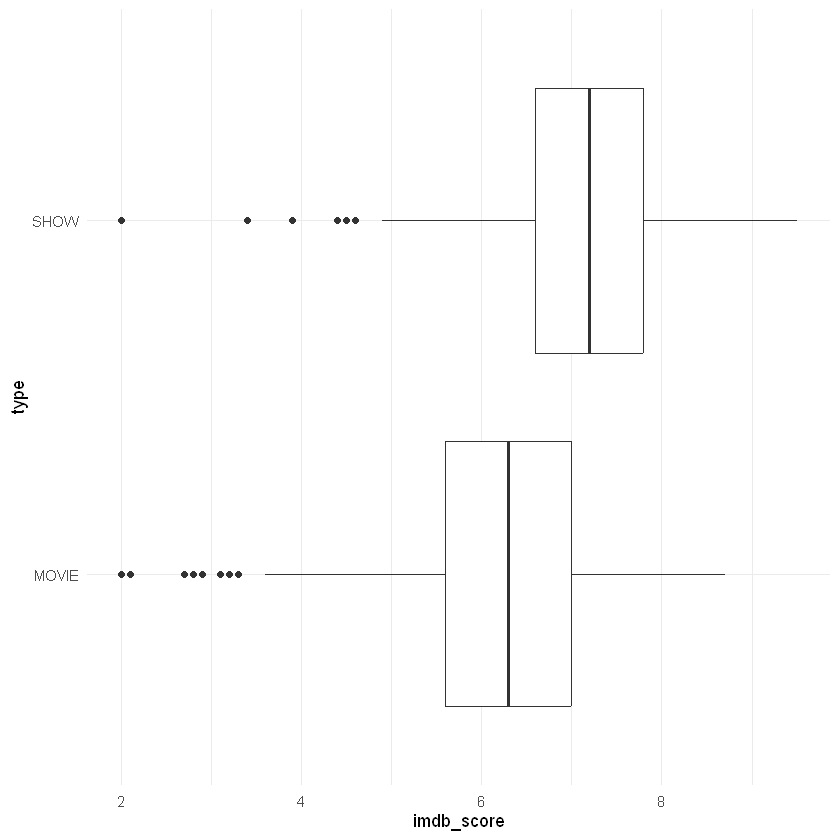

In [15]:
# Check correlation between imdb score and type (show or movie)
ggplot(titles_cleaned, aes(x=imdb_score, y=type)) + geom_boxplot() + theme_minimal()


	Kendall's rank correlation tau

data:  titles_cleaned_movies$imdb_score and titles_cleaned_movies$runtime
z = 7.2596, p-value = 3.883e-13
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1742721 


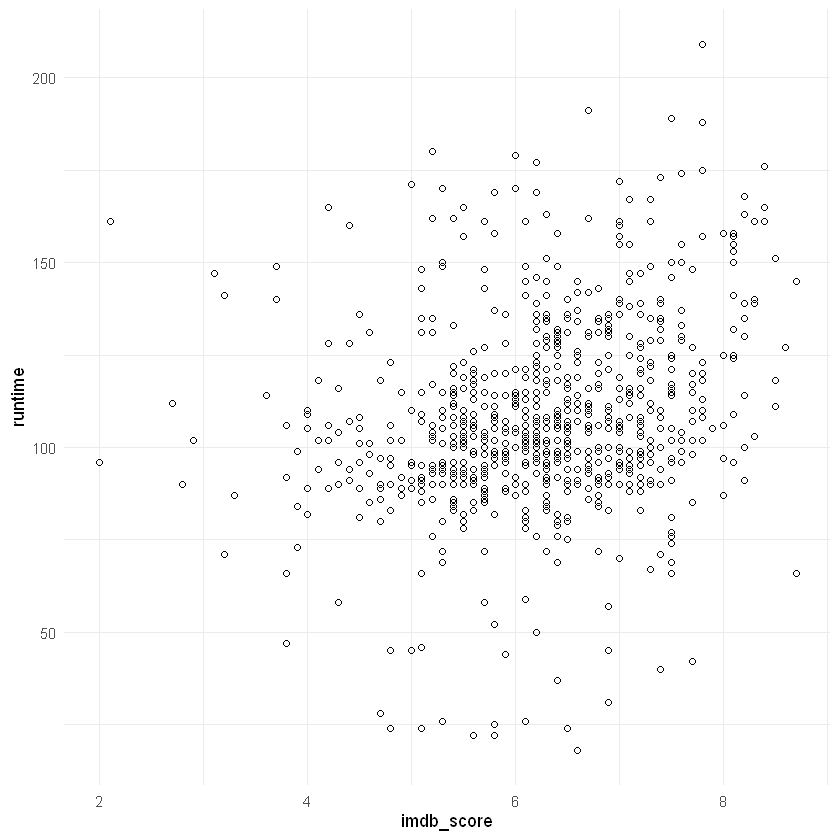

In [16]:
# Check correlation between imdb score and runtime
# split up movies and shows
titles_cleaned_movies = titles_cleaned %>% filter(type =="MOVIE")
ggplot(titles_cleaned_movies, aes(x=imdb_score, y=runtime)) + geom_point(shape=1) + theme_minimal()
# Use Kendall's Tau since there seems to be no linear relation
cor.test(titles_cleaned_movies$imdb_score, titles_cleaned_movies$runtime, method = "kendall")


	Kendall's rank correlation tau

data:  titles_cleaned_shows$imdb_score and titles_cleaned_shows$runtime
z = 4.8186, p-value = 1.446e-06
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1299314 


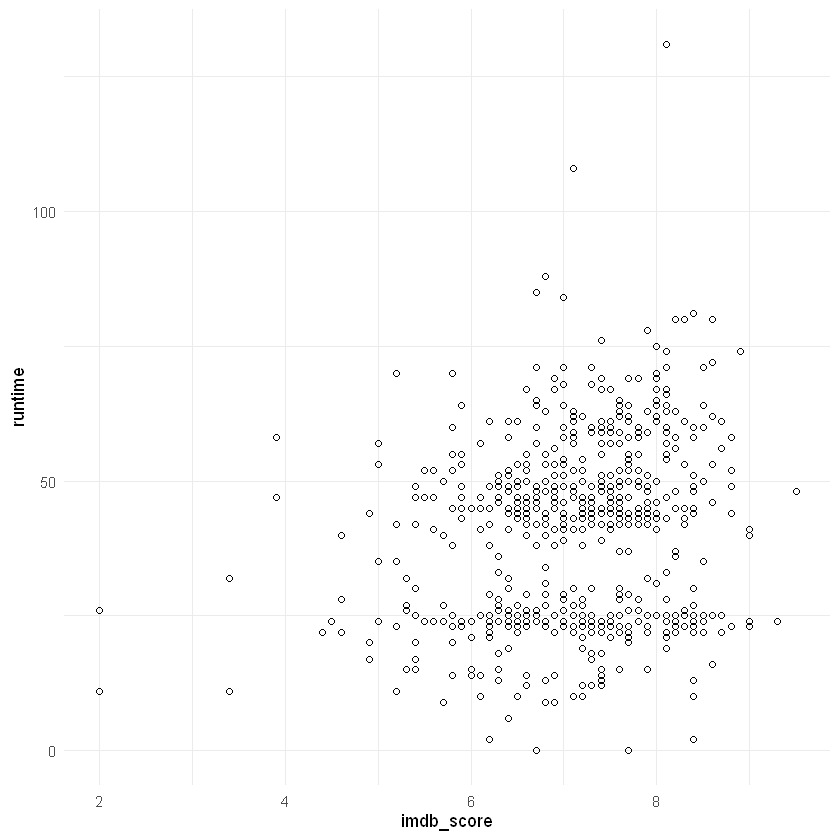

In [17]:
titles_cleaned_shows = titles_cleaned %>% filter(type =="SHOW")
ggplot(titles_cleaned_shows, aes(x=imdb_score, y=runtime)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned_shows$imdb_score, titles_cleaned_shows$runtime, method = "kendall")


	Kendall's rank correlation tau

data:  titles_cleaned_movies$imdb_score and rating_mapping_movie[titles_cleaned_movies$age_certification]
z = 4.1229, p-value = 3.741e-05
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1109212 


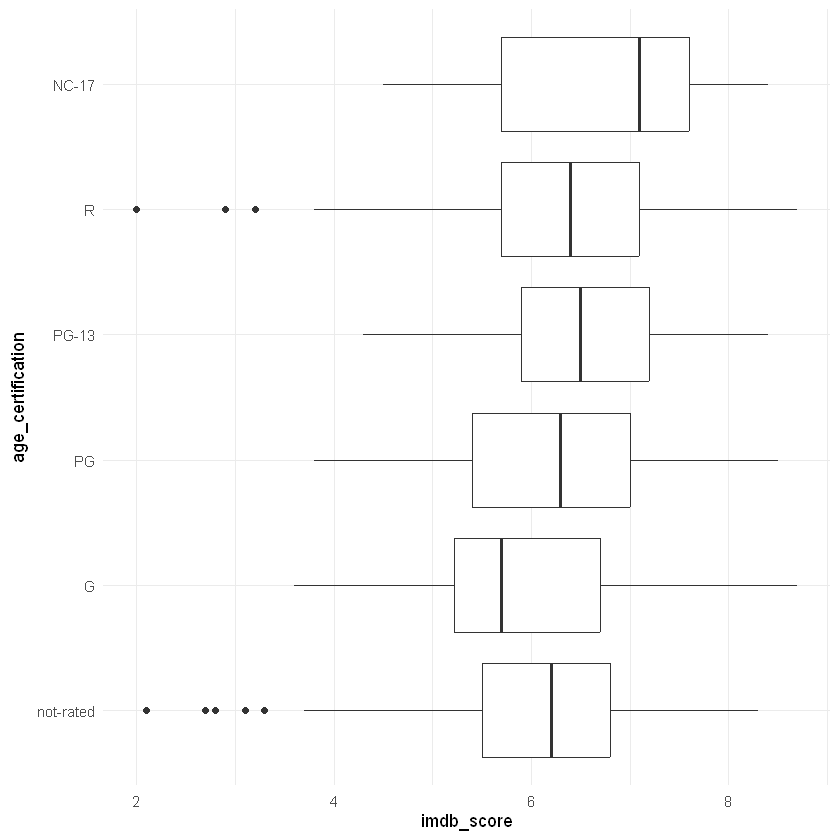

In [18]:
# Check correlation between imdb score and age certification
ggplot(titles_cleaned_movies, aes(x=imdb_score, y=age_certification)) + scale_y_discrete(limits = names(rating_mapping_movie)) + geom_boxplot() + theme_minimal()
cor.test(titles_cleaned_movies$imdb_score, rating_mapping_movie[titles_cleaned_movies$age_certification], method = "kendall")


	Kendall's rank correlation tau

data:  titles_cleaned_shows$imdb_score and rating_mapping_show[titles_cleaned_shows$age_certification]
z = 2.5144, p-value = 0.01192
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.07525643 


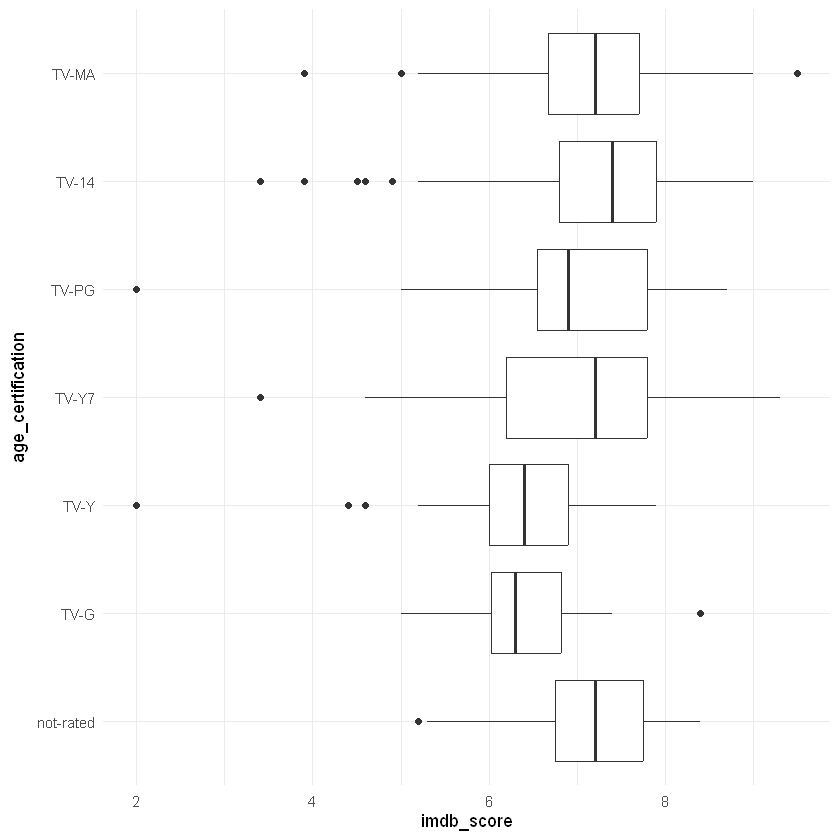

In [19]:
ggplot(titles_cleaned_shows, aes(x=imdb_score, y=age_certification)) + scale_y_discrete(limits = names(rating_mapping_show)) + geom_boxplot() + theme_minimal()
cor.test(titles_cleaned_shows$imdb_score, rating_mapping_show[titles_cleaned_shows$age_certification], method = "kendall")

Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."



	Pearson's product-moment correlation

data:  titles_cleaned$imdb_score and titles_cleaned$imdb_votes
t = 10.205, df = 1455, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2098744 0.3057411
sample estimates:
      cor 
0.2584439 


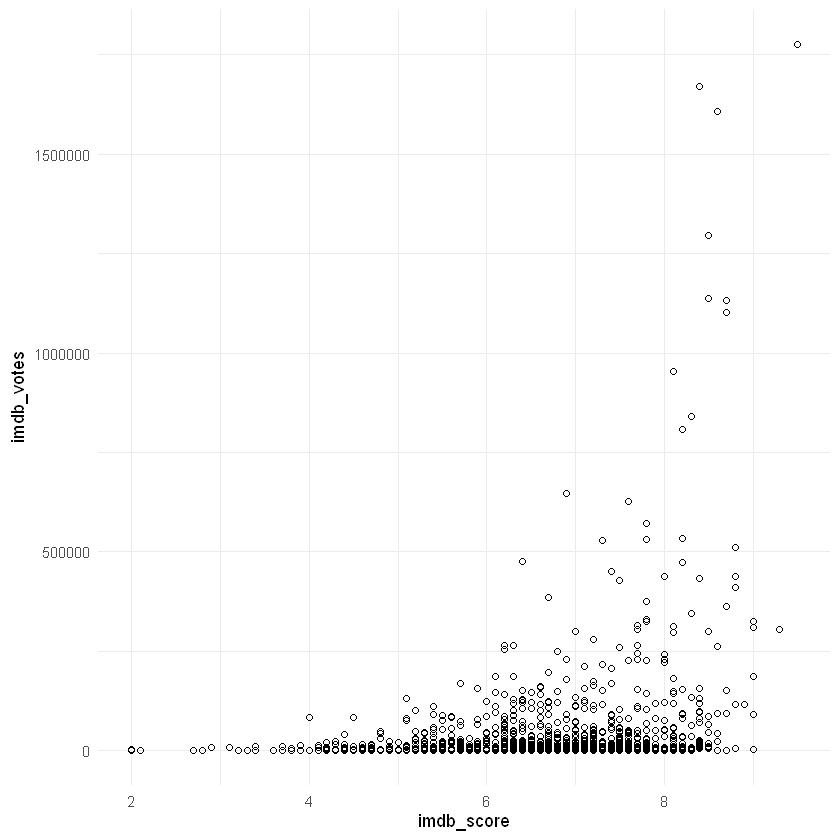

In [20]:
# Check correlation between imdb score and number of votes on imdb
ggplot(titles_cleaned, aes(x=imdb_score, y=imdb_votes)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned$imdb_score, titles_cleaned$imdb_votes)

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_bin()`)."


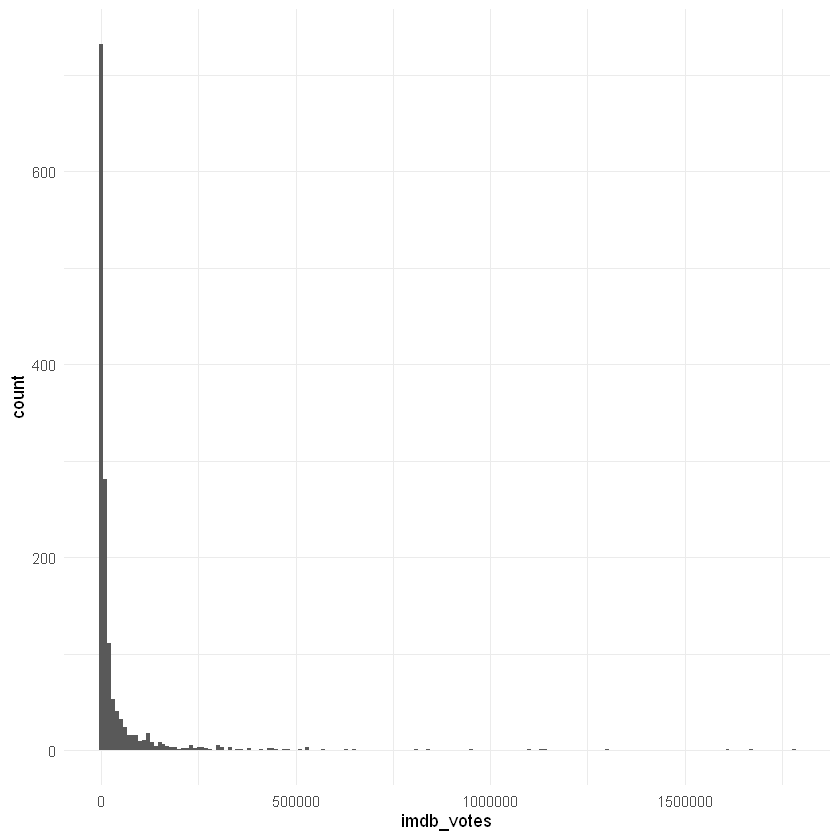

In [21]:
# Check distribution of votes
ggplot(titles_cleaned, aes(x = imdb_votes)) + geom_histogram(binwidth = 10000)  + theme_minimal()

In [22]:
median(titles_cleaned$imdb_votes, na.rm=TRUE)

[1] 4912


	Pearson's product-moment correlation

data:  titles_cleaned$imdb_score and titles_cleaned$release_year
t = -3.9556, df = 1456, p-value = 8.002e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.15363581 -0.05204962
sample estimates:
       cor 
-0.1031116 


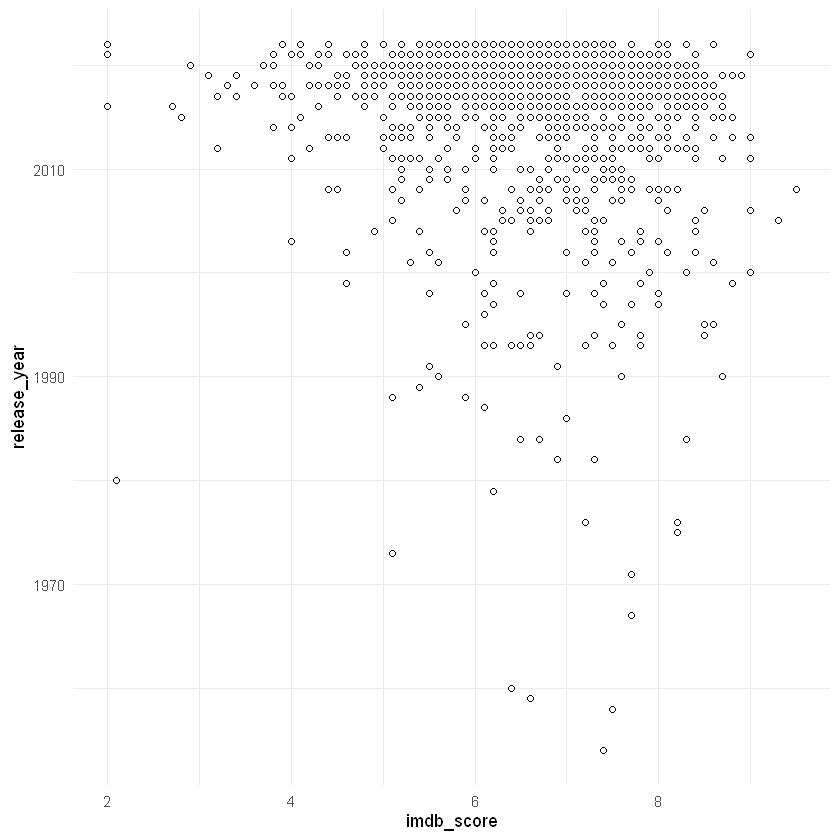

In [23]:
# Check correlation between imdb score and release year
ggplot(titles_cleaned, aes(x=imdb_score, y=release_year)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned$imdb_score, titles_cleaned$release_year)

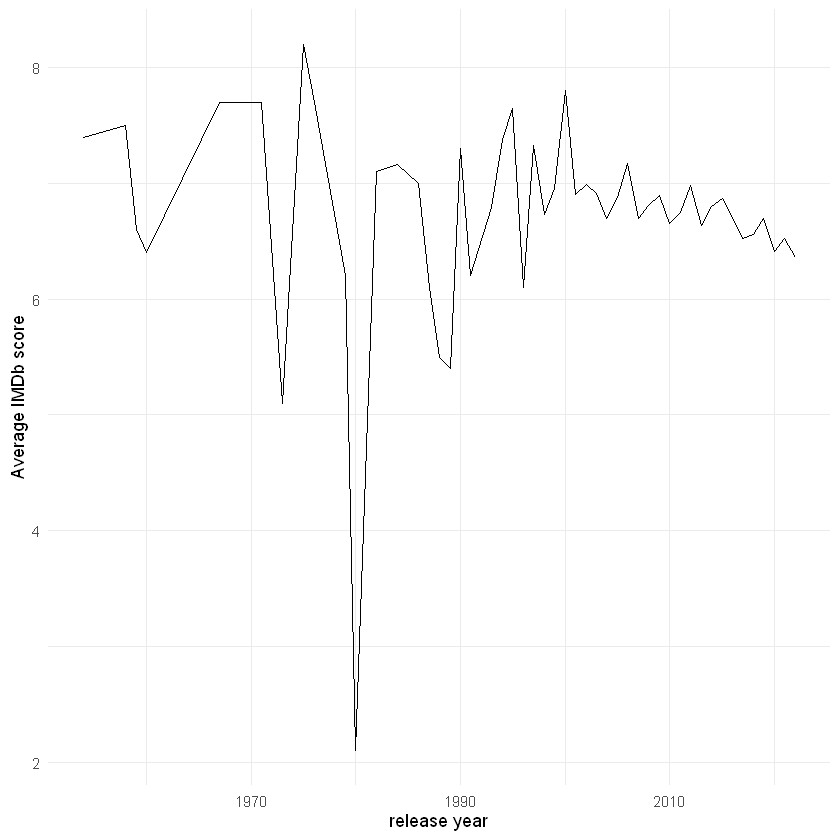

In [24]:
ggplot(titles_cleaned, aes(x = release_year, y = imdb_score)) +
  geom_line(stat = "summary", fun = "mean", color = "black") +
  labs(x = "release year", y = "Average IMDb score") + theme_minimal()

In [25]:
# Create a row for each production country
titles_mutated = titles_cleaned %>% separate_longer_delim(production_countries, delim  = ",")

# Rank countries by total number of movies produced
titles_per_country = titles_mutated %>% 
  group_by(production_countries) %>%
  summarise(total_count = n(),
            imdb_mean = mean(imdb_score, na.rm=TRUE),
            imdb_median = median(imdb_score, na.rm=TRUE),
            tmdb_mean = mean(tmdb_score, na.rm=TRUE),
            tmdb_median = median(tmdb_score, na.rm=TRUE)) %>%
  mutate(rank = rank(-total_count)) %>%
arrange(-total_count) #%>% filter(production_countries %in% c('US', 'MX', 'JP', 'CY', 'IN', 'AE', 'PH', 'CA', 'JO'))

In [26]:
titles_per_country

production_countries,total_count,imdb_mean,imdb_median,tmdb_mean,tmdb_median,rank
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
US,562,6.552669,6.60,6.918475,6.9050,1.0
IN,171,6.516374,6.80,6.421497,6.5000,2.0
JP,130,7.020000,7.00,7.538323,7.5500,3.0
GB,114,6.613158,6.70,6.781728,6.8000,4.0
ES,76,6.419737,6.45,6.800803,6.6715,5.5
FR,76,6.539474,6.40,6.761882,6.7000,5.5
KR,75,7.122667,7.10,7.522293,7.6000,7.0
CA,62,6.296774,6.35,6.745355,6.6500,8.0
DE,43,6.504651,6.70,6.709674,6.9000,9.0


In [27]:
# Compare variance of average per country of imdb and tmdb score
var(titles_per_country$imdb_mean)
var(titles_per_country$tmdb_mean)

[1] 0.7692673

[1] 0.5458981

In [236]:
# Analysis of tmdb score


	Shapiro-Wilk normality test

data:  titles_cleaned$tmdb_score
W = 0.98403, p-value = 1.273e-11


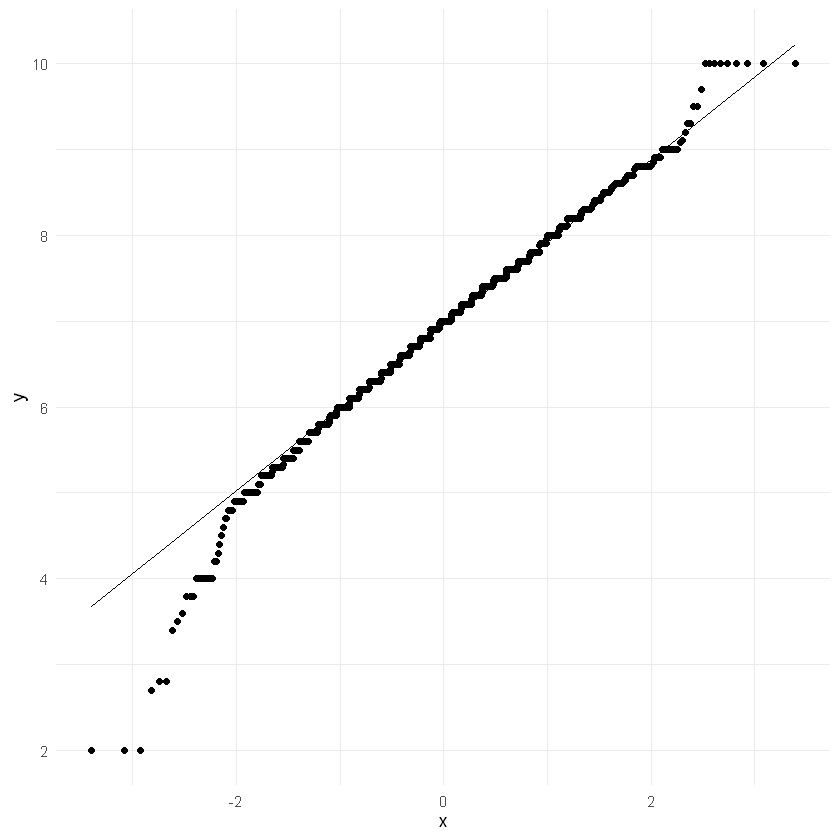

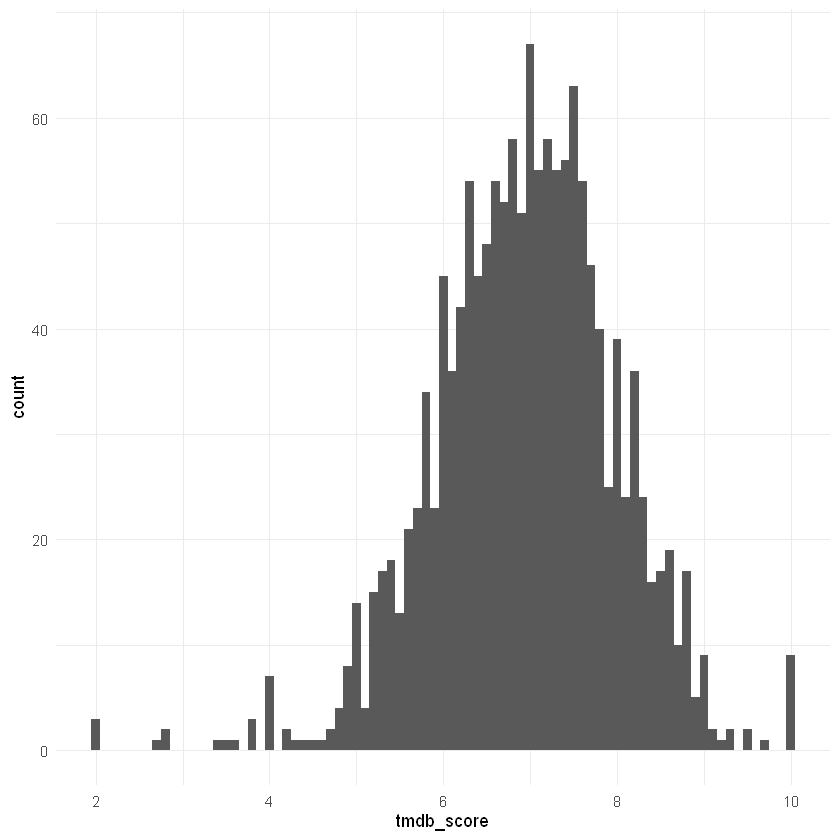

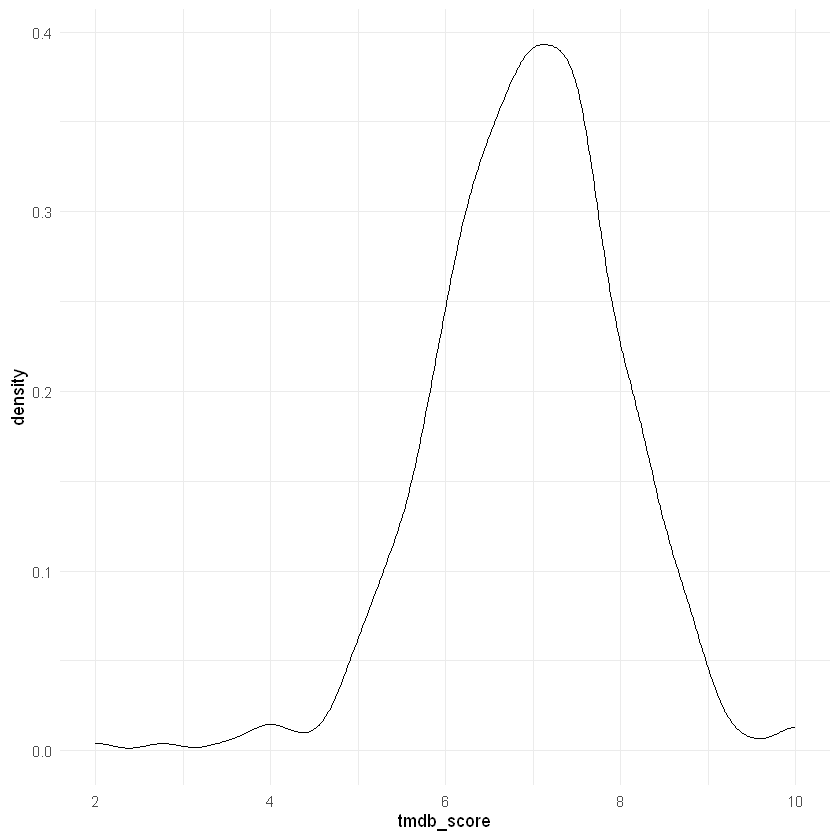

In [237]:
# Check for normality 
shapiro.test(titles_cleaned$tmdb_score)
ggplot(titles_cleaned, aes(sample=tmdb_score)) + stat_qq() + stat_qq_line() + theme_minimal()
ggplot(titles_cleaned, aes(x = tmdb_score)) + geom_histogram(binwidth = 0.1) + theme_minimal()
ggplot(titles_cleaned, aes(x = tmdb_score)) + geom_density() + theme_minimal()

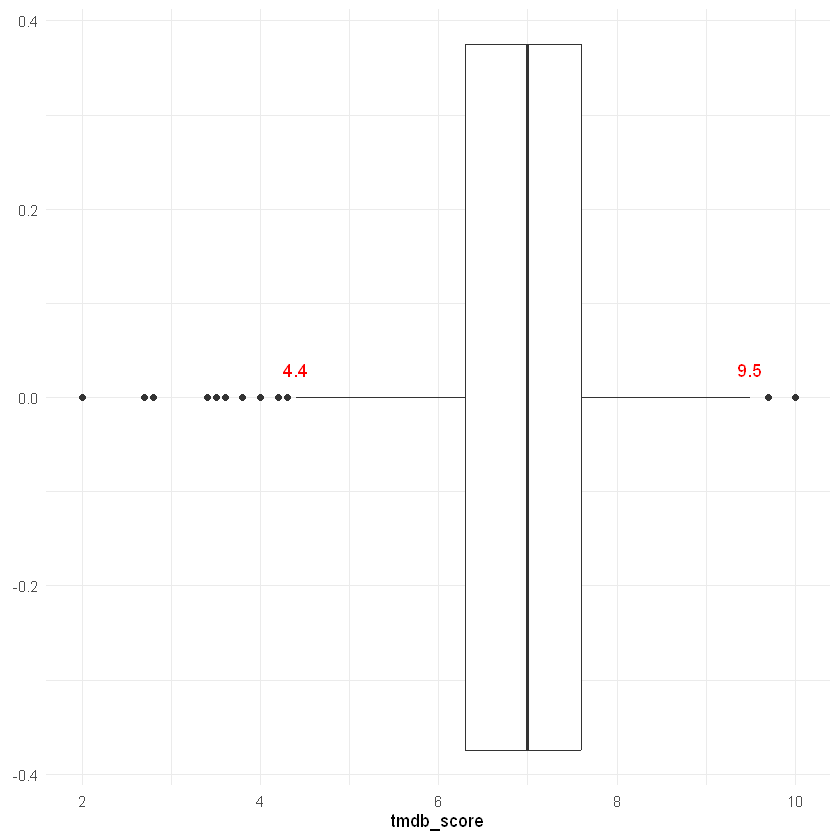

In [238]:
# Check for outliers 
ggplot(titles_cleaned, aes(tmdb_score)) + geom_boxplot() +
  geom_text(
    aes(label = after_stat(xmin), x = stage(tmdb_score, after_stat = xmin)), 
    nudge_y = 0.03, stat = "boxplot", color = "red") + 
geom_text(aes(label = after_stat(xmax), x = stage(tmdb_score, after_stat = xmax)), 
    nudge_y = 0.03, stat = "boxplot", color = "red")  + theme_minimal()

In [239]:
quantile(titles_cleaned$tmdb_score)

0%  25%  50%  75% 100% 
 2.0  6.3  7.0  7.6 10.0

In [240]:
# Show outliers
titles_cleaned %>% filter(tmdb_score < 4.4)

id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,age_certification_num
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tm336403,Khoon Khoon,MOVIE,"As a crazed killer blazes a trail of blood through an anxious city, a hardened cop aims to take him down by any means in this remake of Dirty Harry.",1973,not-rated,131,"crime,thriller",IN,NA,tt0230412,5.1,41,1.948,3.8,0
tm340430,Govindha Govindha,MOVIE,"A Tantric believes that by donating a virgin woman's head to gods crown, would bring down the universe to his feet. How the hero and heroine gets entangled in the underworld nexus, while rescuing the robbery, forms the crux of the plot.",1993,not-rated,145,"drama,action,crime",IN,NA,tt0187096,6.6,356,1.248,4.0,0
tm169128,An Elf's Story,MOVIE,"The inspirational tale of Chippey, the young scout elf who is assigned by Santa to restore Taylor McTuttle's belief in Christmas magic. When the boy breaks the number one Elf on the Shelf rule, Chippey loses his Christmas magic; the entire McTuttle family loses is scout elf, and both Taylor and Chippey lose their self-respect. Through the power of love and forgiveness, both of them learn the most important lesson of all: that true belief cannot be taught.",2011,not-rated,24,"scifi,animation,family,fantasy",US,NA,tt2094761,5.1,510,2.874,2.7,0
tm145658,The Amazing Praybeyt Benjamin,MOVIE,A soldier who once saved the entire country is assigned to guard a genius child whose intellect is needed to foil the plans of an evil villain.,2014,not-rated,105,"drama,comedy,action,fantasy,romance",PH,NA,tt3828220,4.0,195,1.584,3.5,0
tm144451,Cold Harbour,MOVIE,"While investigating a smugglers' turf war in Cape Town, township cop Sizwe discovers police corruption. He must set loyalty aside to act with integrity, alone.",2014,not-rated,76,"thriller,crime,action",ZA,NA,tt3922888,5.2,215,1.955,4.2,0
tm215911,Ludo,MOVIE,"Needing a secluded place for a late-night tryst, two couples stow away in a mall after hours, but are quickly ensnared in a gruesome and deadly game.",2015,not-rated,90,"horror,thriller,fantasy",IN,NA,tt3724898,2.8,852,3.316,2.8,0
tm246810,Santa Banta Pvt Ltd,MOVIE,Two friends and their sweet and endearing misadventures and one of these misadventures sees them land in the middle of a kidnapping investigation.,2016,not-rated,112,"comedy,action,crime,drama",IN,NA,tt2909396,2.7,283,2.241,3.8,0
tm217228,Death Note,MOVIE,"A young man comes to possess a supernatural notebook, the Death Note, that grants him the power to kill any person simply by writing down their name on the pages. He then decides to use the notebook to kill criminals and change the world, but an enigmatic detective attempts to track him down and end his reign of terror.",2017,NC-17,101,"horror,thriller,crime,fantasy,drama,action",US,NA,tt1241317,4.5,84119,22.306,4.2,5
ts86945,Abby Hatcher,SHOW,"Abby Hatcher is part girl, part superhero; living in a world full of fuzzlies. When a fuzzly friend needs help, Abby takes action – going on a mission to make things right.",2018,TV-Y,17,"animation,family,fantasy,comedy",US,3,tt9433014,5.4,182,4.569,4.0,2


In [241]:
titles_cleaned %>% filter(tmdb_score > 9.5)

id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,age_certification_num
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ts55365,The Haunted House,SHOW,"With help from a 102-year-old goblin dwelling beneath their haunted apartment building, two siblings deal with ghosts and take on spooky mysteries.",2016,TV-PG,25,"thriller,horror,animation,comedy,drama,family,fantasy",KR,7,tt9518312,8.3,83,40.650,10.0,4
ts56221,Rainbow Ruby,SHOW,"Rainbow Ruby is the story of a spunky, resourceful little girl who magically transports to Rainbow Village, a whimsical land inhabited by her toys, and transforms into different jobs to help save the day! This CGI-animated preschool series takes the childhood fantasy of dolls come to life, and mixes in an aspirational heroine who proves that you can be anything you want to be!",2016,TV-Y,12,"family,fantasy,animation,comedy",CN,4,tt5828144,6.6,80,12.713,10.0,2
ts95569,Rainbow Rangers,SHOW,"Inspired by the colors of the rainbow, seven magical girls from Kaleidoscopia are guardians of both nature and the Earth.",2018,TV-Y,22,"animation,family,fantasy",US,2,tt7967882,4.4,195,1.499,10.0,2
ts84555,The Unknown Hitman: The Story of El Cholo Adrián,SHOW,"Based on real events, the fictional story of Mexican drug lord El Chato's number one hitman, El Cholo.",2017,TV-MA,50,"action,crime",MX,2,tt6524440,6.6,145,4.376,10.0,6
ts86978,Power Rangers Beast Morphers,SHOW,"Set in the future, a secret agency combines a newly discovered substance called ""Morph-X"" with animal DNA to create the Power Rangers Beast Morphers team. The Rangers must fight off an evil sentient computer virus bent on taking over the source of all Ranger power, the Morphin Grid itself.",2019,TV-Y7,22,"action,animation,scifi,thriller,comedy,drama,fantasy",ES,2,tt8022978,6.5,602,1.802,9.7,3
ts90640,The Writer,SHOW,"When accused of a murder eerily parallel to a plot in his novel, a best-selling crime writer must navigate a web of hidden enemies.",2019,TV-14,37,"drama,crime",LB,1,tt10312958,8.2,32,1.771,10.0,5
ts234501,Buddi,SHOW,"The Buddis bounce, spin, glide and giggle through their magical world, learning new things and sharing the joy of friendship.",2020,TV-Y,10,"family,fantasy,animation,comedy",US,2,tt11829340,7.2,58,1.032,10.0,2
ts342479,Super PupZ,SHOW,"Four pups with superpowers team up to help their new friends and a furry alien comrade in this cuddly, cosmic adventure.",2022,TV-Y7,29,"comedy,family,fantasy,scifi",CA,1,tt18469966,6.6,104,2.232,10.0,3
ts343426,Senzo: Murder of a Soccer Star,SHOW,"Soccer player Senzo Meyiwa was a national hero before his killing shocked South Africa. Who did it, and why? This docuseries dives into the evidence.",2022,TV-MA,42,"crime,sport,documentation","ZA,US",1,tt18954258,5.2,187,2.052,10.0,6


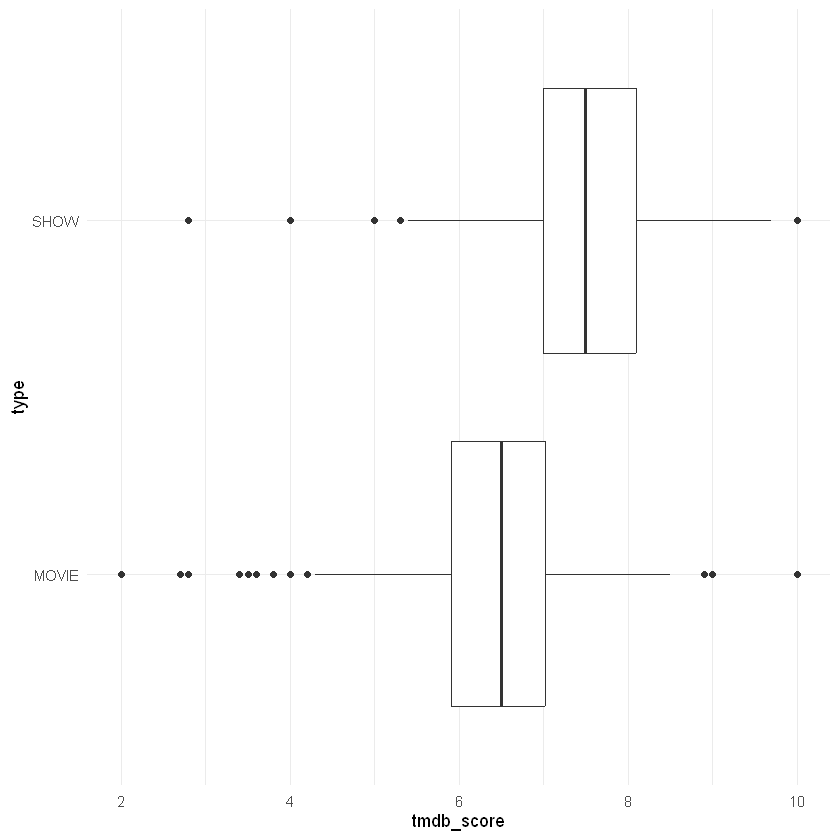

In [170]:
# Check correlation between tmdb score and type (show or movie)
ggplot(titles_cleaned, aes(x=tmdb_score, y=type)) + geom_boxplot() + theme_minimal()


	Kendall's rank correlation tau

data:  titles_cleaned_movies$tmdb_score and titles_cleaned_movies$runtime
z = 3.8899, p-value = 0.0001003
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.09331456 


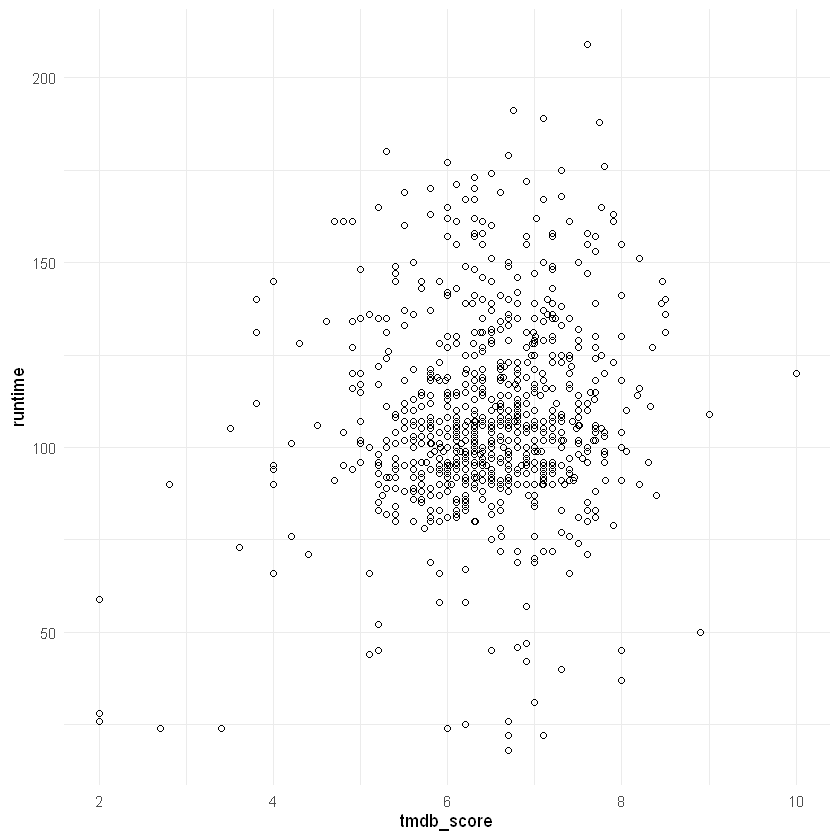

In [319]:
# Check correlation between tmdb score and runtime
ggplot(titles_cleaned_movies, aes(x=tmdb_score, y=runtime)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned_movies$tmdb_score, titles_cleaned_movies$runtime, method = "kendall")


	Kendall's rank correlation tau

data:  titles_cleaned_shows$tmdb_score and titles_cleaned_shows$seasons
z = 5.6568, p-value = 1.542e-08
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1697092 


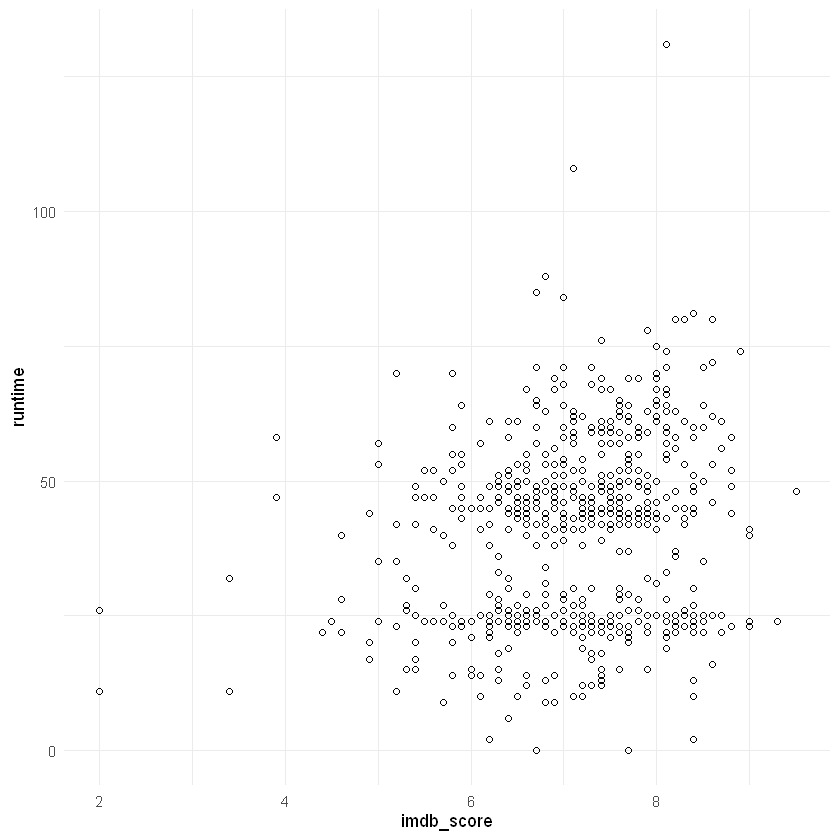

In [322]:
ggplot(titles_cleaned_shows, aes(x=imdb_score, y=runtime)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned_shows$tmdb_score, titles_cleaned_shows$seasons, method = "kendall")


	Kendall's rank correlation tau

data:  titles_cleaned_movies$tmdb_score and rating_mapping_movie[titles_cleaned_movies$age_certification]
z = 3.1337, p-value = 0.001726
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.08424978 


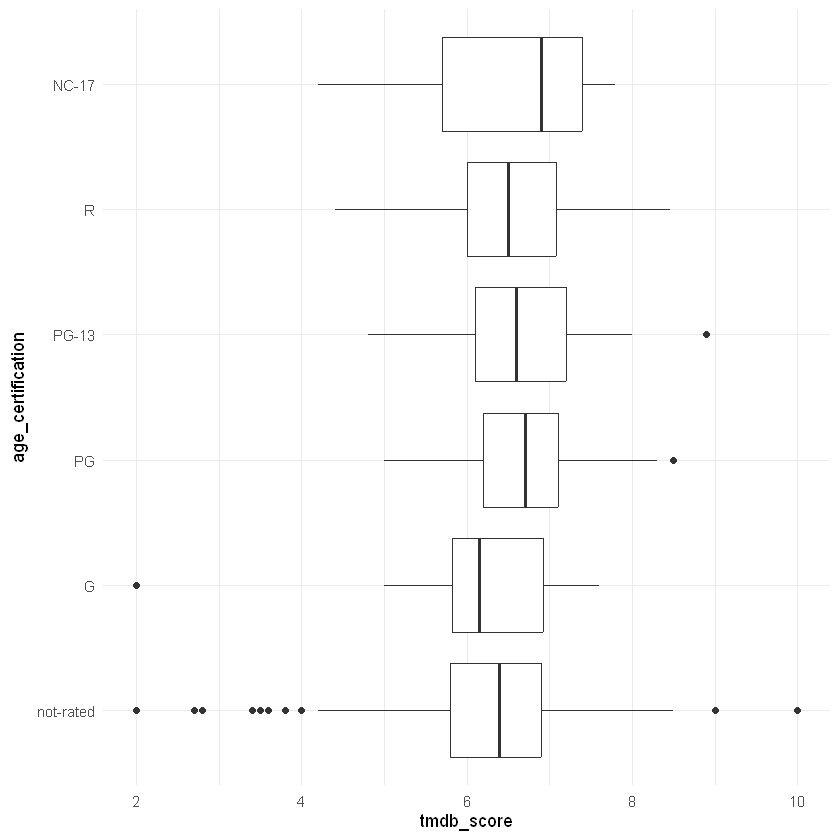

In [323]:
# Check correlation between tmdb score and age certification
ggplot(titles_cleaned_movies, aes(x=tmdb_score, y=age_certification)) + scale_y_discrete(limits = names(rating_mapping_movie)) + geom_boxplot() + theme_minimal()
cor.test(titles_cleaned_movies$tmdb_score, rating_mapping_movie[titles_cleaned_movies$age_certification], method = "kendall")


	Kendall's rank correlation tau

data:  titles_cleaned_shows$tmdb_score and rating_mapping_show[titles_cleaned_shows$age_certification]
z = -3.2916, p-value = 0.0009963
alternative hypothesis: true tau is not equal to 0
sample estimates:
        tau 
-0.09843888 


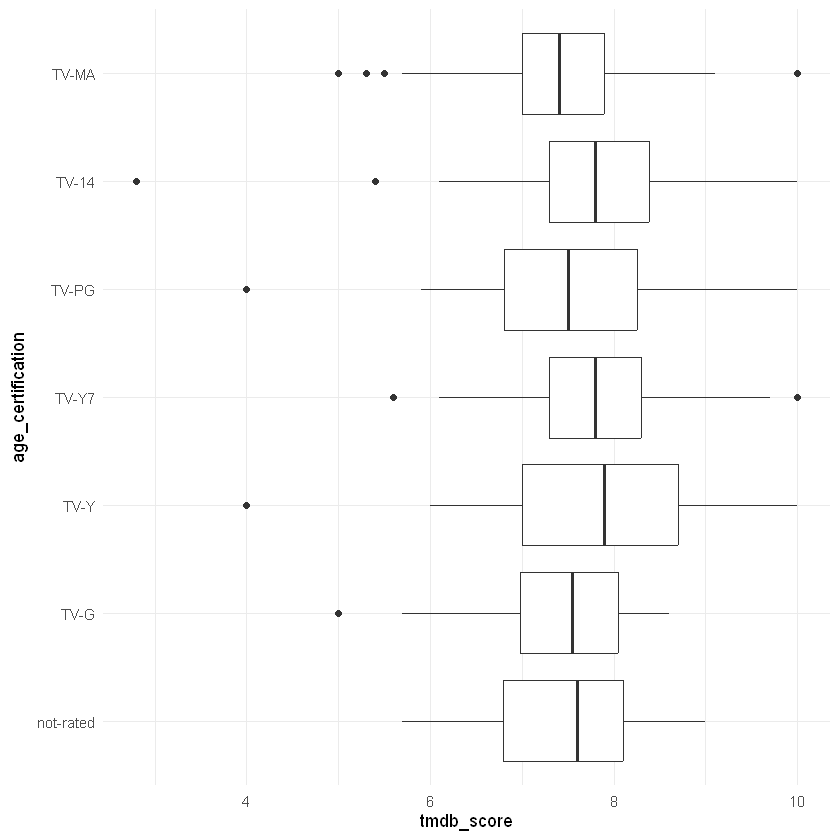

In [324]:
ggplot(titles_cleaned_shows, aes(x=tmdb_score, y=age_certification)) + scale_y_discrete(limits = names(rating_mapping_show)) + geom_boxplot() + theme_minimal()
cor.test(titles_cleaned_shows$tmdb_score, rating_mapping_show[titles_cleaned_shows$age_certification], method = "kendall")


	Pearson's product-moment correlation

data:  titles_cleaned$tmdb_score and titles_cleaned$tmdb_popularity
t = 4.4601, df = 1456, p-value = 8.823e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.06514581 0.16644053
sample estimates:
     cor 
0.116095 


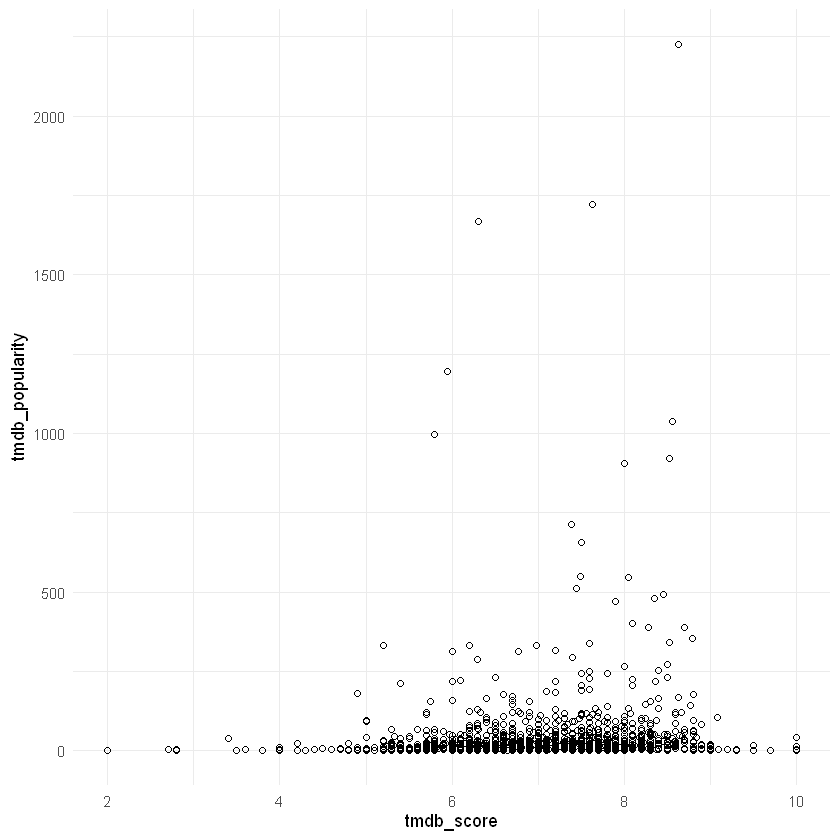

In [326]:
# Check correlation between tmdb score and tmdb popularity
# tmdb popularity does not equal the number of votes but includes different metrics (https://developer.themoviedb.org/docs/popularity-and-trending)
ggplot(titles_cleaned, aes(x=tmdb_score, y=tmdb_popularity)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned$tmdb_score, titles_cleaned$tmdb_popularity)


	Pearson's product-moment correlation

data:  titles_cleaned$tmdb_score and titles_cleaned$release_year
t = 1.8264, df = 1456, p-value = 0.06799
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.003536177  0.098904724
sample estimates:
       cor 
0.04780999 


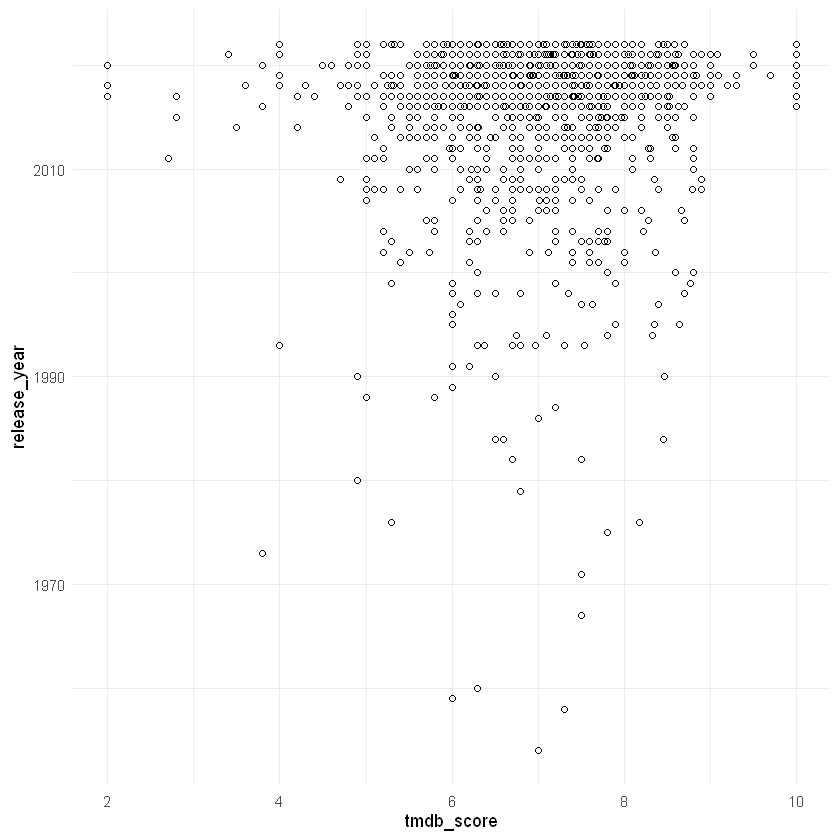

In [142]:
# Check correlation between tmdb score and release year
ggplot(titles_cleaned, aes(x=tmdb_score, y=release_year)) + geom_point(shape=1) + theme_minimal()
cor.test(titles_cleaned$tmdb_score, titles_cleaned$release_year)

In [ ]:
# Test if imdb and tmdb ratings follow similar distributions

In [144]:
# First use Kolmogorov-Smirnov test ratings can be seen as continous but test is probably not accurate due to ties in ratings
ks.test(titles_cleaned$imdb_score, titles_cleaned$tmdb_score)

Warning message in ks.test.default(titles_cleaned$imdb_score, titles_cleaned$tmdb_score):
"im Falle von Bindungen sind die p-Werte approximativ"



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  titles_cleaned$imdb_score and titles_cleaned$tmdb_score
D = 0.12071, p-value = 1.186e-09
alternative hypothesis: two-sided


In [148]:
# Next use Wilcoxon-Mann-Whitney
# group scores by rating platform (imdb = 0, tmdb = 1)
g1 = cbind(score = titles_cleaned$imdb_score, platform = 0)
g2 = cbind(score = titles_cleaned$tmdb_score, platform = 1)
grouped = as.data.frame(rbind(g1, g2))
grouped$platform = as.factor(grouped$platform)
wilcox_test(score ~ platform, data = grouped)


	Asymptotic Wilcoxon-Mann-Whitney Test

data:  score by platform (0, 1)
Z = -7.5238, p-value = 5.322e-14
alternative hypothesis: true mu is not equal to 0


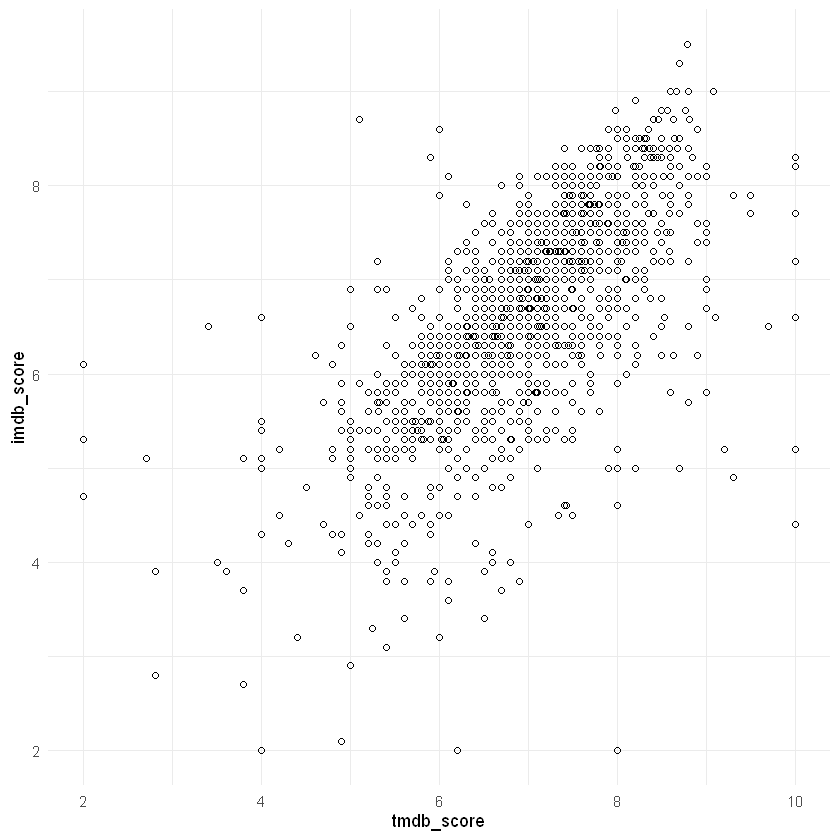

In [50]:
ggplot(titles_cleaned, aes(x=tmdb_score, y=imdb_score)) + geom_point(shape=1) + theme_minimal()

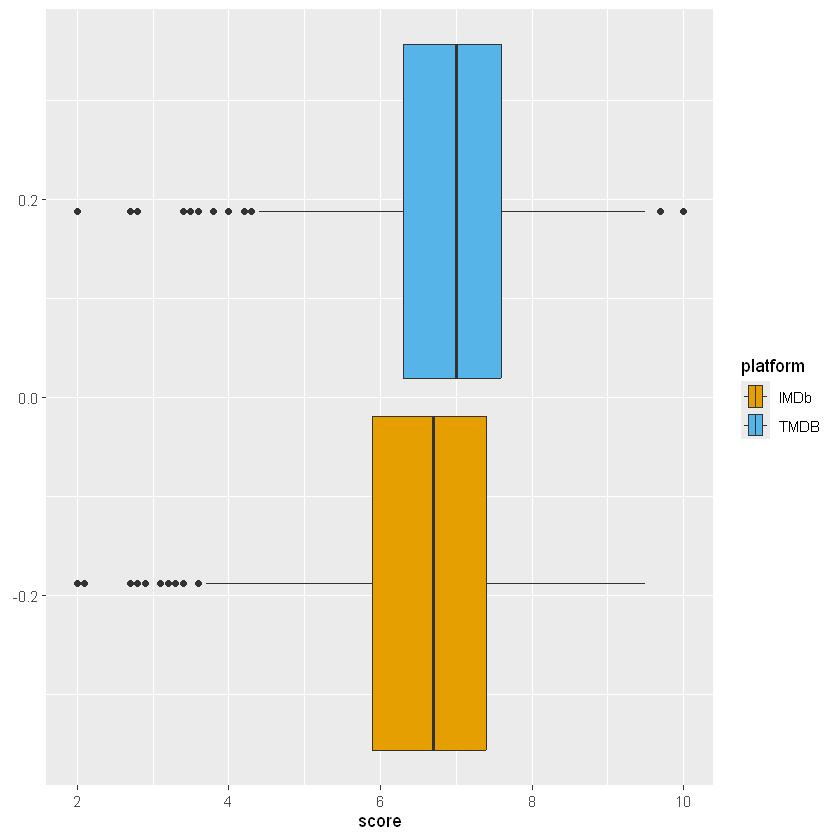

In [156]:
labs = c("IMDb","TMDB")
colors = c("#E69F00","#56B4E9")
ggplot(grouped, aes(x=score, fill=platform)) + scale_fill_manual(labels=labs,values=colors)+ geom_boxplot()

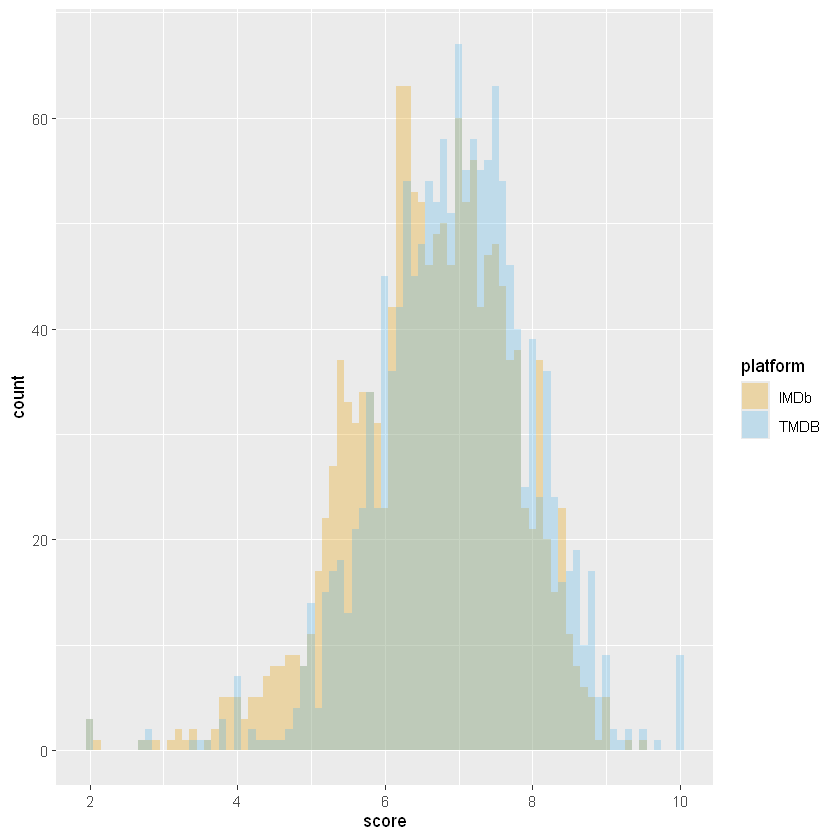

In [157]:
ggplot(grouped, aes(x=score, fill=platform)) + scale_fill_manual(labels=labs,values=colors) + geom_histogram(alpha=0.3, position="identity", binwidth = 0.1)